In [1]:
from database.market import Market
from database.adatabase import ADatabase
import pandas as pd
import matplotlib.pyplot as plt
from processor.processor import Processor as p
from statistics import variance
from tqdm import tqdm
from modeler.modeler import Modeler as m
from datetime import datetime, timedelta

In [2]:
market = Market()
comet = ADatabase("comet")

In [3]:
market.connect()
econ = market.retrieve("econ")
market.disconnect()

In [22]:
comet.connect()
prices = comet.retrieve("coinbase_prices")
market.disconnect()

In [5]:
econ.head()

,date,year,quarter,month,adjclose,fedfunds,gdp,crude,cpi,unemployment
0,2000-02-01,2000.0,1.0,2.0,91.243927,5.676667,1.025235e+13,28.28,63.525534,4.1
1,2000-03-01,2000.0,1.0,3.0,99.833031,5.676667,1.025235e+13,31.71,63.525534,4.0
2,2000-05-01,2000.0,2.0,5.0,95.053322,6.273333,1.025235e+13,25.84,64.181506,4.0
3,2000-06-01,2000.0,2.0,6.0,96.696457,6.273333,1.025235e+13,30.19,64.181506,4.0
4,2000-08-01,2000.0,3.0,8.0,101.635895,6.520000,1.025235e+13,27.85,64.685434,4.1


In [6]:
prices.head()

,date,open,high,low,close,volume,market_cap,crypto
0,2022-01-09,1.182,1.185,1.172,1.182,3844276.90000000,3844276.90000000,ADA
1,2022-01-08,1.209,1.254,1.124,1.181,169730473.68000001,169730473.68000001,ADA
2,2022-01-07,1.279,1.285,1.189,1.210,209806013.19999999,209806013.19999999,ADA
3,2022-01-06,1.230,1.297,1.186,1.280,175754407.59999999,175754407.59999999,ADA
4,2022-01-05,1.310,1.353,1.193,1.230,158740088.19999999,158740088.19999999,ADA


In [23]:
prices = p.column_date_processing(prices)
prices["year"] = [x.year for x in prices["date"]]
prices["quarter"] = [x.quarter for x in prices["date"]]
prices = prices[prices["crypto"].isin(["BTC"])]

In [24]:
data = prices.merge(econ.drop("date",axis=1),on=["year","quarter"],how="left").dropna()

In [28]:
final_data = data.groupby(["year","quarter"]).mean().reset_index()

In [62]:

factors = ["fedfunds","gdp","crude","cpi","unemployment"]
corr_cols = factors
factors.append("close")
final_data[corr_cols].corr()

,fedfunds,gdp,crude,cpi,unemployment,close
fedfunds,1.000000,0.625868,0.804865,0.440149,-0.606650,0.209912
gdp,0.625868,1.000000,0.344455,0.952710,0.088301,0.752796
crude,0.804865,0.344455,1.000000,0.245089,-0.724019,0.149837
cpi,0.440149,0.952710,0.245089,1.000000,0.231490,0.853912
unemployment,-0.606650,0.088301,-0.724019,0.231490,1.000000,0.254443
close,0.209912,0.752796,0.149837,0.853912,0.254443,1.000000


In [29]:

training_data = final_data[final_data["year"]<2019]
prediction = final_data[final_data["year"]>=2019]
refined = {"X":training_data[factors],"y":training_data.rename(columns={"close":"y"})[["y"]]}
models = m.regression(refined)

In [32]:
for row in models.iterrows():
    try:
        model = row[1]["model"]
        api = row[1]["api"]
        score = row[1]["score"]
        prediction[f"{api}_prediction"] = model.predict(prediction[factors])
        prediction[f"{api}_score"] = score
    except:
        continue
included_columns = ["year","week","ticker"]
included_columns.extend([x for x in prediction.columns if "score" in x or "prediction" in x])


In [35]:
prediction

,year,quarter,timestamp,low,high,open,close,volume,month,adjclose,...,gdp,crude,cpi,unemployment,skl_prediction,skl_score,xgb_prediction,xgb_score,cat_prediction,cat_score
14,2019,1,1.550221e+09,3690.986813,3802.985165,3746.915934,3750.261868,7963.290552,2.5,265.935532,...,2.143322e+13,55.525000,93.688690,3.800000,7257.330548,0.834898,5109.223633,0.455417,5769.175257,0.870878
15,2019,2,1.558051e+09,7048.471758,7567.922857,7276.895385,7348.024286,18266.521713,4.5,270.976715,...,2.143322e+13,62.570000,94.924558,3.600000,9031.875620,0.834898,5109.223633,0.455417,5788.753932,0.870878
16,2019,3,1.565957e+09,10000.740109,10630.531739,10365.497174,10340.772500,15489.671028,7.5,282.143021,...,2.143322e+13,56.275000,95.007951,3.700000,8495.972063,0.834898,5109.223633,0.455417,5769.175257,0.870878
17,2019,4,1.573918e+09,7790.137634,8160.890968,7981.807204,7967.100215,9483.015244,10.5,296.785004,...,2.143322e+13,54.820000,95.337926,3.600000,11509.101469,0.834898,7731.131348,0.455417,5659.255899,0.870878
18,2020,2,1.589674e+09,8448.591319,8879.085714,8660.343297,8688.574835,15977.539145,5.0,292.453105,...,2.095303e+13,25.163333,94.648372,12.966667,-91937.255275,0.834898,344.058289,0.455417,2654.403456,0.870878
19,2020,3,1.597615e+09,10412.331398,10809.317957,10626.633656,10646.857634,11777.460761,8.0,322.671463,...,2.095303e+13,41.320000,96.235574,9.050000,-47299.043695,0.834898,346.954102,0.455417,2572.557648,0.870878
20,2020,4,1.605528e+09,16467.418804,17361.730652,16854.035435,17057.836630,16623.013574,11.0,343.070450,...,2.095303e+13,41.525000,96.350188,6.800000,-21285.449971,0.834898,346.954102,0.455417,2572.557648,0.870878


In [39]:
simulation = prediction.groupby(["year","quarter"]).mean().reset_index()
simulation = prices.merge(simulation.drop("close",axis=1),on=["year","quarter"]).dropna()
simulation["average_prediction"] = [sum([row[1][col] for col in simulation.columns if "prediction" in col]) for row in simulation.iterrows()]
simulation["average_prediction"] = simulation["average_prediction"] / 3
simulation["delta"] = (simulation["average_prediction"] - simulation["close"]) / simulation["close"]

In [51]:
positions = 1
start_date = simulation["date"].min()
end_date = simulation["date"].max()
reqs = [1,5,10,30]
limit = 7
values = [False]
trades = []
for value in tqdm(values):
    for req in tqdm(reqs):
        for position in range(positions):
            date = start_date
            iterration_sim = simulation.copy()
            if not value:
                iterration_sim["delta"] = iterration_sim["delta"] * -1
            while date < end_date:
                try:
                    todays_recs = iterration_sim[iterration_sim["date"]==date]
                    todays_recs.sort_values("delta",ascending=False,inplace=True)
                    if todays_recs.index.size > 0:
                        offering = todays_recs.iloc[position]
                        if offering["delta"] > req:
                            trade = offering
                            ticker = trade["crypto"]
                            buy_price = trade["close"]
                            exits = iterration_sim[(iterration_sim["crypto"]==ticker) & (iterration_sim["date"]>date)].iloc[:limit]
                            exits["gains"] = (exits["close"] - buy_price) / buy_price
                            exit = exits.sort_values("gains",ascending=False).iloc[0]
                            trade["sell_price"] = exit["close"]
                            trade["sell_date"] = exit["date"]
                            date = exit["date"] + timedelta(days=1)
                            trade["value"] = value
                            trade["req"] = req
                            trade["position"] = position
                            trades.append(trade)
                        else:
                            date = date + timedelta(days=1)
                    else:
                        date = date + timedelta(days=1)
                except Exception as e:
                    print(str(e))
                    date = date+timedelta(days=1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.47s/it]


In [52]:
t = pd.DataFrame(trades)
t["delta"] =  (t["sell_price"] - t["close"]) / t["close"]

In [53]:
analysis = []
for value in tqdm(values):
    for req in tqdm(reqs):
        for position in range(positions):
            position_trades = t[(t["value"]==value) & (t["req"]==req) & (t["position"]==position)].sort_values("date")
            position_trades["delta"] = (position_trades["sell_price"] - position_trades["close"]) / position_trades["close"]
            initial = 100
            for delta in position_trades["delta"]:
                initial = initial * (1+delta)
            analysis.append({
                "value":value,
                "req":req,
                "position":position,
                "pv":initial
            })

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.98it/s]


In [54]:
complete = pd.DataFrame(analysis).pivot_table(index=["value","req"],columns="position",values="pv").reset_index()

In [55]:
complete["pv"] = [sum([row[1][i] for i in range(1)]) for row in complete.iterrows()]
complete.sort_values("pv",ascending=False)

position,value,req,0,pv
0,False,1,441.037855,441.037855
1,False,5,162.832940,162.832940
2,False,10,100.000000,100.000000
3,False,30,100.000000,100.000000


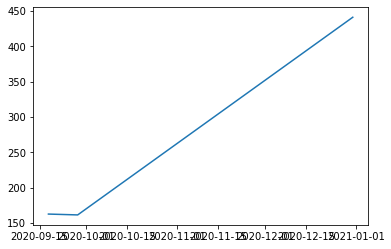

In [60]:
best_iteration = t[(t["value"]==False) & (t["req"]==1)].copy()
pivoted = best_iteration.pivot_table(index="sell_date",columns="position",values="delta").fillna(0)
for i in range(1):
    pv = []
    initial = 100
    for delta in pivoted[i]:
        initial = initial * (1+delta)
        pv.append(initial)
    pivoted[f"pv_{i}"] = pv
pivoted["pv"] = [sum([row[1][f"pv_{i}"] for i in range(1)]) for row in pivoted.iterrows()]
pivoted.reset_index(inplace=True)
window = pivoted[pivoted["sell_date"]>datetime(2020,1,1)]
plt.plot(window["sell_date"],window["pv"])

In [61]:
best_iteration

,timestamp_x,low_x,high_x,open_x,close,volume_x,date,crypto,year,quarter,...,xgb_score,cat_prediction,cat_score,average_prediction,delta,sell_price,sell_date,value,req,position
550,1585785600,6570.92,7292.11,6666.11,6804.52,28761.008041,2020-04-01,BTC,2020,2,...,0.455417,2654.403456,0.870878,-29646.264510,0.628329,11080.00,2020-09-18,False,1,0
371,1600560000,10759.37,11081.37,11081.09,10920.89,6003.785091,2020-09-19,BTC,2020,3,...,0.455417,2572.557648,0.870878,-14793.177315,-0.007340,10840.73,2020-09-28,False,1,0
453,1601424000,10657.04,10847.00,10839.98,10779.63,6318.529438,2020-09-29,BTC,2020,3,...,0.455417,2572.557648,0.870878,-14793.177315,1.728557,29412.84,2020-12-31,False,1,0
